# Signal over Path Testing
The signal_over_path function is designed to model the response of a beam oscillating sinusoidally over the detector with a user-specified amplitude and period, and to output the signals from the detector.

In [7]:
# %load detector.py
"""
This code defines functions needed to create a gaussian laser beam
and mask it according to the specifications of our quandrant cell photodiode.
"""

import numpy as np
import numpy.ma as ma
from scipy import integrate
from quadrantdetector.sample_functions import periodogram_psd


def laser(diameter, n, x_c, y_c, sigma):
    """
    This cute function uses the wondrousness of NumPy to produce a gaussian
    beam in one line of code. The resulting array will be masked in the
    compute_signals function to eliminate the beam outside the detector
    and also to account for the dead zones due to the gap.

    Parameters
    ----------
    diameter : float
        Diameter of full detector (in mm)
    n : int
        Number of chunks to divide detector into, rounded up to the nearest
        even number.
    x_c, y_c : float
        x and y Cartesian coordinates of the center of the laser spot
        (not necessarily on the detector!)
    sigma : float
        the standard deviation for the gaussian beam; FWHM ~ 2.355σ

    Returns
    -------
    array_like
        NumPy array of normalized beam intensity values over the detector array
    """
    delta = diameter/n
    y, x = np.mgrid[-diameter/2 + delta/2: diameter/2 + delta/2: delta, -diameter/2 + delta/2: diameter/2 + delta/2: delta]
    return 1 / (2 * np.pi * sigma ** 2) \
        * (np.exp(-((x - x_c) ** 2 + (y - y_c) ** 2) / (2 * sigma ** 2)))
        

def intensity(y, x, sigma):
    """ Computes the intensity of a Gaussian beam centered on the origin at the position (x,y)"""
    return (1/(2*np.pi*sigma**2)) * np.exp(-(x**2 + y**2)/(2*sigma**2))


        
def total_signal(delta, sigma, R):
    """ Computes the theoretical sum signal by numerical integration; 
        Assumes a centered beam.
    """
    signal = 4* integrate.dblquad(intensity, delta/2, np.sqrt(R**2 - 0.25*delta**2), delta/2,
                               lambda x: np.sqrt(R**2 - x**2), args=(sigma,))[0]
    return signal


def n_critical(diameter, gap):
    """
    This function computes the smallest even integer value for the number of
    cells, n_crit, is such that no more than 2 complete cells fall within the
    detector gap width δ (i.e. Δ = δ/2 yielding N = 2 d0/δ)
    The code makes sure that N is even.

    Parameters
    ----------
    diameter : float
        The diameter of the quadrant cell photo diode (in mm)
    gap : float
        The gap distance between the quadrants of the photo diode (in mm)

    Returns
    -------
    n_crit : int
        The critical number of cells (an even number)

    """
    critical = int(2 * diameter / gap)
    if critical % 2 != 0:
        critical += 1
    return critical


def create_detector(n, diameter, gap, roundoff=1e-14):
    """
    This routine creates the entire detector array. It does so by assuming a
    square array and eliminating chunks not within the circular detector
    boundary.

    Parameters
    ----------
    n : int
        Number of chunks to divide detector into, rounded up to the nearest
        even number.
    diameter : float
        Diameter of full detector (in mm)
    gap : float
        Gap width between the quadrants of the detector (in mm)
    roundoff : float
        Scalar fudge factor needed for round-off error (default = 1e-14)

    Returns
    -------
    active_area : array_like
        2d array with effective area of each cell; if the cell is dead,
        it's area will be zero. Most cells will have and area of (diameter/n)**2,
        but some cells which straddle the gap will have a fraction of this area. 

    Note
    ----
    From the Numpy masking module np.ma manual:

    A masked array is the combination of a standard numpy.ndarray
    and a mask. A mask is either nomask, indicating that no value
    of the associated array is invalid, or an array of booleans
    that determines for each element of the associated array whether
    the value is valid or not.

    When an element of the mask is False, the corresponding element
    of the associated array is valid and is said to be unmasked.

    When an element of the mask is True, the corresponding element
    of the associated array is said to be masked (invalid).

    In other words, for the code below, I want to create an array of
    values where the laser beam's intensity is specified for all points
    within the detector's active radius. The easiest way to do this is to
    assign the value TRUE to all points within this radius. BUT, in numpy's
    way of thinking, these points are to be neglected (masked); however,
    since the logical equivalent to TRUE is 1, a mutiplication of this mask
    with the x and y arrays will yield an array with the points outside the
    detector eliminated. Technically, I am using my mask in the OPPOSITE manner
    in which numpy intends.
    """

    # If odd, round up.
    if n % 2:
        n = n + 1
     
    # The maximum possible gap size is sqrt(2)*Radius of detector;
    # raise an exception if this condition is violated:   
    if gap >= np.sqrt(2)*diameter/2:
        raise Exception('The gap is too large!')
        
        
    delta = diameter / n
    y, x = np.mgrid[-diameter / 2 + delta / 2: diameter / 2 + delta / 2: delta,
                    -diameter / 2 + delta / 2: diameter / 2 + delta / 2: delta]
    # This computes the distance of each grid point from the origin
    # and then we extract a masked array of points where r_sqr is less
    # than the distance of each grid point from the origin:
    r_sqr = x ** 2 + y ** 2 

    inside = ma.getmask(ma.masked_where(r_sqr <= (diameter / 2) ** 2, x))

    # This portion takes care of masking out elements of the detector where
    # the gap exists. It returns an array of light intensity over the detector.

    all_dead = (np.abs(x) + delta / 2 - roundoff > gap / 2) \
        & (np.abs(y) + delta / 2 - roundoff > gap / 2)

    partial_dead_x_only = (np.abs(x) + delta / 2 - roundoff > gap / 2) & \
                          (np.abs(x) - delta / 2 - roundoff < gap / 2) & \
                          (np.abs(y) - delta / 2 - roundoff > gap / 2)
    partial_dead_y_only = (np.abs(y) + delta / 2 - roundoff > gap / 2) & \
                          (np.abs(y) - delta / 2 - roundoff < gap / 2) & \
                          (np.abs(x) - delta / 2 - roundoff > gap / 2)
    partial_dead_x_or_y = (1 / delta) * (np.abs(x) + delta / 2 - gap / 2) * partial_dead_x_only + \
                          (1 / delta) * (np.abs(y) + delta / 2 - gap / 2) * partial_dead_y_only

    partial_dead_x_and_y = (1 / delta ** 2) * (np.abs(x) + delta / 2 - gap / 2) ** 2 * \
                           (
                            (np.abs(x) + delta / 2 - roundoff > gap / 2) &
                            (np.abs(x) - delta / 2 - roundoff < gap / 2) &
                            (np.abs(y) + delta / 2 - roundoff > gap / 2) &
                            (np.abs(y) + delta / 2 - roundoff > gap / 2) &
                            (np.abs(y) - delta / 2 - roundoff < gap / 2) &
                            (np.abs(x) + delta / 2 - roundoff > gap / 2)
                           )

    gap_mask = all_dead  # not strictly needed, but
    partial_mask = partial_dead_x_or_y + partial_dead_x_and_y
    partial_mask[partial_mask == 0] = 1
    active_area = inside * gap_mask * partial_mask * delta ** 2

    return active_area


def compute_signals(beam, area):
    """
    This routine computes--for a given beam intensity--
    the sum, left-right, and top-bottom signals.

    Parameters
    ----------
    beam : array_like
        Array of laser beam intensity
    area : array_like
        Array representing the detector.

    Returns
    -------
    sum_signal : float
        Sum of all 4 quadrants
    l_r : float
        Left minus right quadrants
    t_b : float
        Top minus bottom quadrants
    """
    signal = beam * area
    x_shape, y_shape = signal.shape
    right = np.sum(signal[0:x_shape, int(y_shape / 2):y_shape])
    left = np.sum(signal[0:x_shape, 0:int(y_shape / 2)])
    bottom = np.sum(signal[0:int(x_shape / 2), 0:y_shape])
    top = np.sum(signal[int(x_shape / 2):x_shape, 0:y_shape])
    return np.sum(signal), left - right, top - bottom


def signal_over_path(n, diameter, gap, x_max, sigma, track,
                     n_samples, roundoff=1e-14):
    """
    This routine executes the compute_signals function multiple times over
    a user specified path function and returns the path and the expected
    signals.

    Parameters
    ----------
    n : int
        Number of cells to divide diameter up into
    diameter : float
        Diameter of detector in mm
    gap : float
        Gap width between quadrants of detector in mm
    x_max : float
        horizontal domain for sweeping across detector x from -xmax to +xmax
    sigma : float
        Width of gaussian beam,
    track
        A function describing path across detector. Must take the
        arguments (x, d0).
    n_samples : int
        Number of samples in domain; dx = 2 * xmax / n_samples
    roundoff : float
        Fudge factor needed for roundoff error (default = 1e-14)

    Returns
    -------
    xp : array_like
        list of x coordinates for path
    sum_signal : array_like
        List of the sums of all 4 quadrants
    l_r : array_like
        List of the left minus right quadrants
    t_b : array_like
        List of the top minus bottom quadrants
    """
    xp = np.linspace(-x_max, x_max, n_samples)  # create x coordinate array
    area = create_detector(n, diameter, gap, roundoff)
    all_results = [compute_signals(laser(area, diameter / n, x_val,
                                   track(x_val, diameter), sigma), area)
                   for x_val in np.nditer(xp)]
    return (xp, *zip(*all_results))


def signal_over_time(n, diameter, gap, amplitude, period, t_max, sigma, track,
                     n_samples, roundoff=1e-14):
    """
    This routine executes the compute_signals function multiple times over
    a user specified TIME interval and returns the path and the expected
    signals.
    This routine is more relevant to someone using a quadrant cell
    detector as a way top measure zero crossings of torsional pendulum
    undergoing angular oscillations with amplitude significantly greater that
    the effective angular amplitude defined by the detector. That being said,
    this function allows the users to specify the amplitude to any value
    desired.


    Parameters
    ----------
    n : int
        The number of cells to divide diameter up into
    diameter : float
        Diameter of detector in mm
    gap : float
        Gap width between quadrants of detector in mm
    amplitude : float
        Amplitude of sinusoidal motion
    period : float
        Period of sinusoidal signal in seconds
    t_max : float
        Maximum time for simulation in seconds
    sigma : float
        width of gaussian beam in mm
    track
        name of function describing path across detector. Must take the
        arguments (x, d0).
    n_samples : int
        number of samples in time domain; dt = 2*t_max/n_samples
    roundoff : float
        Fudge factor needed for roundoff error (default = 1e-14)

    Returns
    -------
    tp : array_like
        List of time values in seconds
    xp : array_like
        :ist of x coordinates for path
    sum_signal : float
        Sum of all 4 quadrants
    l_r : float
        Left minus right quadrants
    t_b : float
        Top minus bottom quadrants

    Notes
    -----
    1. the track function specifies the y-coordinate of the spot
    center as it tracks across the detector.
    2. The period of the motion is set to mimic our pendulum with
    its current torsion fiber (40 seconds)
    """

    # create time array
    tp = np.linspace(0, t_max, n_samples)

    # create x coordinate array
    xp = amplitude * np.sin(2 * np.pi * tp / period)
    yp = track(tp, diameter)

    area = create_detector(n, diameter, gap,
                           roundoff=roundoff)

    all_sig = [compute_signals(laser(diameter, n, x_val, y_val, sigma), area)
               for x_val, y_val in np.nditer([xp, yp])]

    return (tp, xp, *zip(*all_sig))


def power_spectrum(n, d0, gap, tmax, σ, track_func, n_samples, amplitude):
    """
    This code uses the functions in physics.py to build a detector and
    simulate the motion of our laser on some path across the detector.

    """
    #   Physical Paramaters for our detector system:
    #
    #    d0  # diameter of photocell in mm
    #    gap   # gap between the 4 quadrants; also in mm
    #    σ   # measured gaussian radius of our laser beam
    #
    #   Simulation Parameters:
    #
    #    n           # choose a reasonable minimum n value
    #    ϵ           # fudge factor due to roundoff error in case where δ = 2Δ
    delta = d0 / n  # grid size for simulation
    #    t_max       # maximum time to run for
    #    n_samples   # number of samples for path in time
    #    track_func  # path of laser across detector
    #    amplitude   # amplitude of oscillation in mm
    print("Building: ", n, "by", n, " Array")
    print("Pixel Size: Δ = %.3f " % delta)

    #   Now build the detector and return the detector response for a gaussian
    #   beam centered at (xc, yc) illuminating the detector.

    tp, xp, s, lr, tb = signal_over_time(n, d0, gap, t_max, sigma,
                                         track_func, n_samples, amplitude)
    f_lr, psd_lr = periodogram_psd(lr, n_samples / t_max)
    f_tb, psd_tb = periodogram_psd(tb, n_samples / t_max)
    return tp, xp, s, lr, tb, f_lr, psd_lr, f_tb, psd_tb

def center_path(x, d0):
    """
    Describes the y values of a a straight path across the center of a
    detector given a position x and detector diameter d0.

    """
    return 0.0

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
#signal_over_time(n, diameter, gap, amplitude, period, t_max, sigma, track, n_samples, roundoff=1e-14)
t, x, s, lr, tb = signal_over_time(n=1000, diameter=10, gap=0.1, amplitude=5, period=1, t_max=20, 
                                   sigma=3,track=center_path, n_samples=200, roundoff=1e-14)

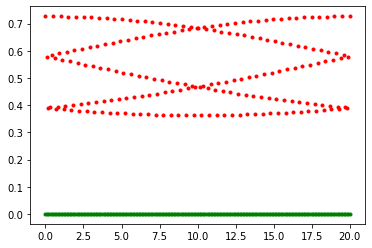

In [43]:
plt.plot(t,s,'r.')
plt.plot(t, tb, 'g.')
plt.show()